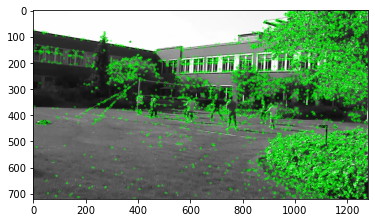

In [87]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from skimage.feature import register_translation
#import skimage.registration.phase_cross_correlation


img1 = cv2.imread("image1.png")
img2 = cv2.imread("image2.png")

grayimg1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
grayimg2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

keyp1, desc1 = sift.detectAndCompute(grayimg1, None)
keyp2, desc2 = sift.detectAndCompute(grayimg2, None)

keyImage1 = cv2.drawKeypoints(grayimg1, keyp1, np.array([]), (0, 255, 0))
keyImage2 = cv2.drawKeypoints(grayimg2, keyp2, np.array([]), (0, 255, 0))

plt.imshow(keyImage1)

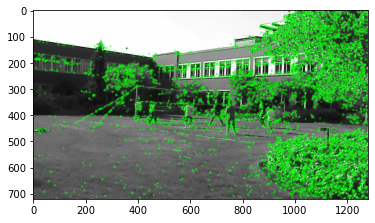

In [88]:
plt.imshow(keyImage2)

Length of Matches Using KNN Approach: 3
Brute-Force Matching Image Representation:


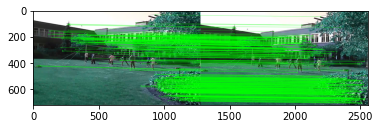

In [97]:
brutef = cv2.BFMatcher()
matches = brutef.knnMatch(desc1, desc2, k=2)

def knnMatch():
    knnMatch = []
    for m, n in (matches):
        if m.distance < 0.255*n.distance:
            knnMatch.append(m)
    return knnMatch
knnMatch = knnMatch()

def euclidean_distance(desc1, desc2):
    distance = 0.0
    for i in range(len(desc1)-1):
        distance += (desc1[i] - desc2[i])**2
    return np.sqrt(distance)

def get_neighbors(desc1, test_row, num_neighbors):
    distances = list()
    for train_row in desc1:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))   
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors
neighbors = get_neighbors(desc1,desc1[0],3)

matchImage = cv2.drawMatches(img1, keyp1, img2, keyp2, knnMatch, np.array([]), (0, 255, 0), flags=2)

eu = euclidean_distance(matchImage, matchImage[0])
gn = get_neighbors(matchImage,matchImage[0],3)
print("Length of Matches Using KNN Approach:",len(gn))

print("Brute-Force Matching Image Representation:")
plt.imshow(matchImage)

Length of matches Using FlannBased Approach:  595


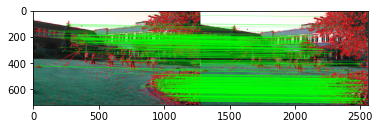

(<matplotlib.image.AxesImage at 0x1fb385cca90>, None)

In [90]:
FLANN_INDEX_KDTREE = 1
indexparams=dict (algorithm=FLANN_INDEX_KDTREE, trees=5)
searchparams=dict (checks=50)

flann=cv2.FlannBasedMatcher(indexparams, searchparams)
matches=flann.knnMatch(desc1, desc2, k=2)

def flannMatch():
    flannMatch = []
    for m, n in (matches):
        if m.distance < 0.255*n.distance:
            flannMatch.append(m)
    return flannMatch
flannMatch = flannMatch()

print("Length of matches Using FlannBased Approach: ",len(flannMatch))

matchesmask=[[0,0] for i in range (len(matches))]
for i, (m, n) in enumerate (matches):
    if m.distance<0.255 * n.distance:
        matchesmask [i]=[1,0]
drawparams=dict (matchColor=(0,255,0), singlePointColor =(255,0,0), matchesMask = matchesmask, flags=cv2.DrawMatchesFlags_DEFAULT)
resultimage=cv2.drawMatchesKnn(img1, keyp1, img2, keyp2, matches, None, ** drawparams)
plt.imshow (resultimage,), plt.show ()

Affine Tranformation:
 [[ 9.61648487e-01 -5.07346476e-01  2.52716860e+02]
 [ 1.17478326e-01  7.23537079e-01 -6.20973277e+01]]


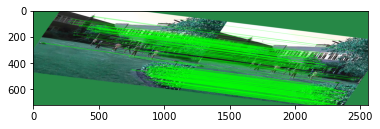

In [91]:
from scipy import misc

y, x = matchImage.shape[:2]
fx = float(x)
fy = float(y)
src_point = np.float32([[fx/2, fy/3,], [2*fx/3, 2*fy/3], [fx/3, 2*fy/3]])
     
random_limits=(0.8, 1.1)
random_shift = (np.random.rand(3,2) - 0.5) * 2 * (random_limits[1]-random_limits[0])/2 + np.mean(random_limits)

dst_point = src_point * random_shift.astype(np.float32)
transform = cv2.getAffineTransform(src_point, dst_point)
print("Affine Tranformation:\n",transform)

borderValue = 0
if matchImage.ndim == 3:
    borderValue = np.median(np.reshape(matchImage, (matchImage.shape[1]*matchImage.shape[0],-1)), axis=0)
else:
    borderValue=np.median(matchImage)
warped_img = cv2.warpAffine(matchImage, transform, dsize=(x,y), borderValue=borderValue)

plt.imshow(warped_img)

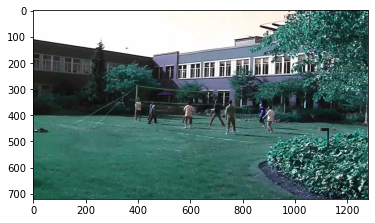

In [92]:
h1, w1 = img2.shape[:2]
h2, w2 = img1.shape[:2]
pts1 = np.float64([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts2 = np.float64([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
pts2_ = cv2.perspectiveTransform(pts2, transform)
pts = np.concatenate((pts1, pts2), axis=0)

[xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
t = [-xmin, -ymin]

Ht = np.array([[1, t[0]], [0, t[1]], [0, 1]])

result = cv2.warpPerspective(img1, Ht.dot(transform), (xmax-xmin, ymax-ymin))
result[t[1]:h1+t[1], t[0]:w1+t[0]] = img2

plt.imshow(result)

In [93]:
import warnings
from skimage.registration import phase_cross_correlation

shifted, error, diffphase = phase_cross_correlation(img1, img2)
xoff = -shifted[1]
yoff = -shifted[0]

print("Image Registrayion Error: ",error)
print("phase_differance: ",diffphase)
print("Detected pixel offset: ", xoff, yoff)



Image Registrayion Error:  0.394626512227057
phase_differance:  1.425790541119738e-17
Detected pixel offset:  -11.0 16.0


In [94]:
print("The best Matches Using KNN Approach:",(len(gn)))
print("The best Matches Using FLannBased Approach:",(len(flannMatch)))


The best Matches Using KNN Approach: 3
The best Matches Using FLannBased Approach: 595
